In [1]:
import pystac_client
import planetary_computer as pc

import rasterio
import rioxarray as rioxr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import shapely
import os

from shapely.geometry import shape

In [2]:
YEAR = 2018

## Access NAIP image collection in Planetary Computer
Adapted from sample notebook in Planetary Computer NAIP example code

In [3]:
# accesing Azure storage using pystac client
URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = pystac_client.Client.open(URL)

In [4]:
# Bounding box around Campus Point
# created using https://boundingbox.klokantech.com
area_of_interest = {
    "type": "Polygon",
    "coordinates": [[
        [-119.8610195981,34.3938837903],
        [-119.8306927339,34.3938837903],
        [-119.8306927339,34.420119945],
        [-119.8610195981,34.420119945],
        [-119.8610195981,34.3938837903]
    ]],
}
# Temporal range of interest
date_range = str(YEAR)+'-01-01/'+str(YEAR)+'-12-31'

# look in NAIP catalog for items on specified date and geographic range
search = catalog.search(
    collections=["naip"], 
    intersects=area_of_interest, 
    datetime=date_range
)

items = list(search.get_items())
print(f"{len(items)} item(s) found")

1 item(s) found


In [5]:
# choose the item that has the most overlap:
area_shape = shape(area_of_interest)
target_area = area_shape.area

def area_of_overlap(item):
    overlap_area = shape(item.geometry).intersection(shape(area_of_interest)).area
    return overlap_area / target_area

item = sorted(items, key=area_of_overlap, reverse=True)[0]

In [6]:
def print_dict(dictionary):
    for key, value in dictionary.items():
        print(key, ' : ', value)
    print('\n')
    return

print(item)
print('type:', type(item), '\n')
print_dict(item.properties)
print_dict(item.assets)

<Item id=ca_m_3411934_sw_11_060_20180722_20190209>
type: <class 'pystac.item.Item'> 

gsd  :  0.6
datetime  :  2018-07-22T00:00:00Z
naip:year  :  2018
proj:bbox  :  [235476.0, 3807168.0, 241728.0, 3814572.0]
proj:epsg  :  26911
naip:state  :  ca
proj:shape  :  [12340, 10420]
proj:transform  :  [0.6, 0.0, 235476.0, 0.0, -0.6, 3814572.0, 0.0, 0.0, 1.0]


image  :  <Asset href=https://naipeuwest.blob.core.windows.net/naip/v002/ca/2018/ca_060cm_2018/34119/m_3411934_sw_11_060_20180722_20190209.tif>
metadata  :  <Asset href=https://naipeuwest.blob.core.windows.net/naip/v002/ca/2018/ca_fgdc_2018/34119/m_3411934_sw_11_060_20180722.txt>
thumbnail  :  <Asset href=https://naipeuwest.blob.core.windows.net/naip/v002/ca/2018/ca_060cm_2018/34119/m_3411934_sw_11_060_20180722_20190209.200.jpg>
tilejson  :  <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/tilejson.json?collection=naip&item=ca_m_3411934_sw_11_060_20180722_20190209&assets=image&asset_bidx=image%7C1%2C2%2C3>
rendered_pr

In [7]:
# sign and open item
href = pc.sign(item.assets["image"].href)
ds = rasterio.open(href)
print(type(ds))

<class 'rasterio.io.DatasetReader'>


In [8]:
# Explore opened dataset
print('type: ', type(ds))
print('mode: ', ds.mode)
print('# bands: ', ds.count, '\n')

print('collection date:', item.datetime, '\n')
      
print('height: ',ds.height)
print('width: ', ds.width, '\n')
      
print('CRS: ', ds.crs)      
print('spatial bounding box: ')
print(ds.bounds)
print('affine transform: ')
print(ds.transform)   # see also get_transform() and read_transform()
print('resolution:', ds.res)

type:  <class 'rasterio.io.DatasetReader'>
mode:  r
# bands:  4 

collection date: 2018-07-22 00:00:00+00:00 

height:  12340
width:  10420 

CRS:  EPSG:26911
spatial bounding box: 
BoundingBox(left=235476.0, bottom=3807168.0, right=241728.0, top=3814572.0)
affine transform: 
| 0.60, 0.00, 235476.00|
| 0.00,-0.60, 3814572.00|
| 0.00, 0.00, 1.00|
resolution: (0.6, 0.6)


In [9]:
# check image
# some re-arranging of the order of the bands needs to be doe to fd it into .imshow
#plt.imshow(np.moveaxis(ds.read(indexes=[1,2,3]),0,-1)) 

## Select GBIF year data

In [10]:
# this data was saved to memory from GBIF datset on the Planetary Comp
# see notebook selecting_gbif_data

gbifdata = 'c_edulis_observations.csv'
obs_all = pd.read_csv(os.path.join(os.getcwd(),'aux_data',gbifdata))

obs_all = gpd.GeoDataFrame(
    obs_all,
    crs = "EPSG:4326",
    geometry = gpd.points_from_xy(
        x= obs_all.decimallongitude,
        y= obs_all.decimallatitude)
)


print('# observations:', obs_all.shape[0])
print('# columns:', obs_all.shape[1], '\n')
print(obs_all.columns)
#obs_all.head()

# observations: 427
# columns: 52 

Index(['Unnamed: 0', 'gbifid', 'datasetkey', 'occurrenceid', 'kingdom',
       'phylum', 'class', 'order', 'family', 'genus', 'species',
       'infraspecificepithet', 'taxonrank', 'scientificname',
       'verbatimscientificname', 'verbatimscientificnameauthorship',
       'countrycode', 'locality', 'stateprovince', 'occurrencestatus',
       'individualcount', 'publishingorgkey', 'decimallatitude',
       'decimallongitude', 'coordinateuncertaintyinmeters',
       'coordinateprecision', 'elevation', 'elevationaccuracy', 'depth',
       'depthaccuracy', 'eventdate', 'day', 'month', 'year', 'taxonkey',
       'specieskey', 'basisofrecord', 'institutioncode', 'collectioncode',
       'catalognumber', 'recordnumber', 'identifiedby', 'dateidentified',
       'license', 'rightsholder', 'recordedby', 'typestatus',
       'establishmentmeans', 'lastinterpreted', 'mediatype', 'issue',
       'geometry'],
      dtype='object')


In [11]:
# select data for yeear of interest: YEAR defined at top of notebok

obs = obs_all.loc[obs_all['year'] == YEAR]
obs = obs[['year',
           'month',
           'geometry', 
           'decimallatitude', 'decimallongitude', 
           'coordinateuncertaintyinmeters',
           'institutioncode']]
obs.reset_index(drop=True, inplace=True)
print('# observations:', obs.shape[0])
obs.head()

# observations: 62


,year,month,geometry,decimallatitude,decimallongitude,coordinateuncertaintyinmeters,institutioncode
0,2018.0,4.0,POINT (-122.53049 38.00750),38.007500,-122.530487,5.0,iNaturalist
1,2018.0,12.0,POINT (-121.91021 36.62163),36.621633,-121.910213,NaN,iNaturalist
2,2018.0,4.0,POINT (-122.48073 37.79367),37.793672,-122.480735,14.0,iNaturalist
3,2018.0,6.0,POINT (-120.86054 35.37261),35.372605,-120.860542,5.0,iNaturalist
4,2018.0,2.0,POINT (-122.43967 37.43072),37.430723,-122.439666,4.0,iNaturalist


In [12]:
# Remove those above certain threshold for accuracy?
# keeping all for the time being
np.unique(obs.coordinateuncertaintyinmeters)

array([4.00e+00, 5.00e+00, 6.00e+00, 1.00e+01, 1.20e+01, 1.40e+01,
       1.60e+01, 1.39e+02, 1.86e+02, 2.37e+02, 4.72e+03,      nan,
            nan,      nan,      nan,      nan,      nan,      nan,
            nan,      nan,      nan,      nan,      nan,      nan,
            nan,      nan,      nan,      nan,      nan,      nan,
            nan,      nan,      nan,      nan,      nan,      nan,
            nan,      nan,      nan,      nan,      nan,      nan,
            nan,      nan,      nan,      nan,      nan,      nan])

<AxesSubplot:>

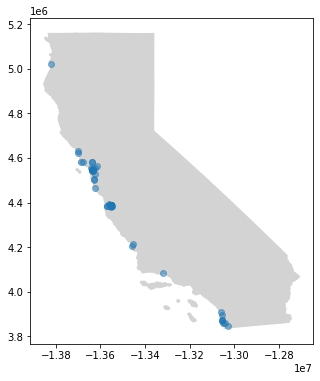

In [13]:
# ---- plot observations over california ----
ca_shape_path = "/home/jovyan/msai4earth-esa/shapefiles_n_rasters/CA_geometry/CA_State_TIGER2016.shp"
ca_shape = gpd.read_file(ca_shape_path)

fig, ax = plt.subplots(figsize = (6,6))
ca_shape.plot(ax=ax, color='lightgrey')
obs[['geometry']].to_crs(ca_shape.crs).plot(ax=ax, alpha=0.5)

In [14]:
# Match observation crs with NAIP crs
obs = obs[['geometry']]
obs['geometry'] = obs['geometry'].to_crs(ds.crs)

## USE POINTS TO EXTRACT BANDS INFO FROM NAIP IMAGE

To extract information about the NAIP image we will use the dataset method `sample()` from `ds`, which is a `rasterio.io.DatasetReader`. This method will return an iterable object, remember this can omly be iterated through once.

See more at:
https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html

Because not all coordinates will be within the NAIP image, some of the samples will be [0,0,0,0]. We need to discard those.

In [18]:
fp = os.path.join(os.getcwd(),'aux_data','observations-220884.csv')
obs16 = gpd.GeoDataFrame(
    pd.read_csv(fp), 
    crs = "EPSG:4326",
    geometry = gpd.points_from_xy(
        x= pd.read_csv(fp).longitude, 
        y= pd.read_csv(fp).latitude)
)

#********** CHECK IF THIS IS REALLY THE BEST WAY TO DO THIS *******
obs16['geometry'] = obs16['geometry'].to_crs(ds.crs)
obs16.shape

(14, 39)

In [19]:
# Find points within NAIP image

naip_box = shapely.geometry.box(*ds.bounds)

# *******************************************************************
# ***** UPDATE ALL THIS TO JUST SUBSETING THE obs geodataframe *****
df = []
for point in obs16['geometry']:
    if naip_box.contains(point):
        df.append(point)

naip_obs = gpd.GeoDataFrame()
naip_obs['geometry']=df
naip_obs.set_crs(ds.crs, inplace=True)
# *******************************************************************

save = False
if(save):
    naip_obs.to_file(os.path.join(os.getcwd(),'aux_data','naip16_obs.shp'))
naip_obs

,geometry
0,POINT (238399.666 3810854.686)
1,POINT (238161.595 3810936.091)
2,POINT (238396.613 3810861.015)
3,POINT (238156.566 3810942.123)
4,POINT (238168.362 3810934.317)
5,POINT (238402.912 3810859.251)
6,POINT (236880.057 3811269.448)
7,POINT (235950.976 3811945.415)


In [17]:
# we will need this form for the coordiantes to extract bands
naip_obs['xy'] = naip_obs.geometry.apply(lambda p: (p.x,p.y))

sample = ds.sample(naip_obs.xy)

data = []
for i in sample:
    if (i!= [0,0,0,0]).all():  # **** THIS IS NOT NEEDED BC WE FILTERED TO PTS WITHING IMAGE ***
        data.append(i)
data = np.vstack(data)
data = pd.DataFrame(data, columns=['r','g','b','nifr'])
data

,r,g,b,nifr
0,29,30,39,47
1,62,57,63,112
2,123,107,102,141
3,63,55,57,101
4,84,81,74,126
5,141,133,121,140
6,103,105,84,137
7,62,59,60,133


## Opening polygons extracted from QGIS

How to generate a new list of polygons in QGIS
https://www.youtube.com/watch?v=knD2S89FV04

How to open NAIP images directly on QGIS using the STAC plugin
https://planetarycomputer.microsoft.com/docs/overview/qgis-plugin/
https://stac-utils.github.io/qgis-stac-plugin/user-guide/

Randomly sample points in polygons
https://gis.stackexchange.com/questions/294394/randomly-sample-from-geopandas-dataframe-in-python


In [21]:
fp = os.path.join(os.getcwd(),'aux_data','polygons_2016/trial.shp')
trial_polys = gpd.read_file(fp)
trial_polys

,id,geometry
0,0,"POLYGON ((-119.84689 34.40631, -119.84356 34.4..."
1,1,"POLYGON ((-119.84710 34.41094, -119.84223 34.4..."
2,2,"POLYGON ((-119.86752 34.41834, -119.85331 34.4..."


In [19]:
trial_polys.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

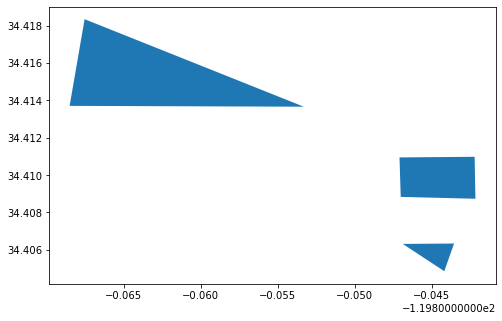

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches((8,8))
trial_polys.plot(ax=ax)

In [21]:
from shapely.geometry import Point
import random

######
def random_points_in_polygon(number, polygon):
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < number:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
            i += 1
    return points  
######

In [22]:
i=2
points = random_points_in_polygon(20,trial_polys['geometry'][i])
# ********** SIMPLIFY THIS ***************
geo_points = gpd.GeoDataFrame()
geo_points['geometry']=points
geo_points.set_crs(trial_polys.crs,inplace=True)
# *******************************************************************
geo_points.head()

,geometry
0,POINT (-119.86364 34.41476)
1,POINT (-119.86591 34.41448)
2,POINT (-119.86760 34.41503)
3,POINT (-119.85476 34.41409)
4,POINT (-119.86190 34.41512)


<AxesSubplot:>

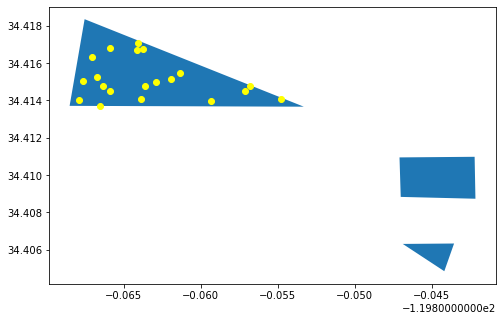

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches((8,8))
trial_polys.plot(ax=ax)
geo_points.plot(ax=ax, color="yellow")

## Sample NAIP image data at random points

In [28]:
geo_points['geometry'] = geo_points['geometry'].to_crs(ds.crs)
geo_points.crs

<Derived Projected CRS: EPSG:26911>
Name: NAD83 / UTM zone 11N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [29]:
geo_points['xy'] = geo_points.geometry.apply(lambda p: (p.x,p.y))
sample = ds.sample(geo_points.xy)
sample
data = []
for i in sample:
    if (i!= [0,0,0,0]).all():  # **** THIS IS NOT NEEDED BC WE FILTERED TO PTS WITHING IMAGE ***
        data.append(i)
data = np.vstack(data)
data = pd.DataFrame(data, columns=['r','g','b','nifr'])
data

,r,g,b,nifr
0,92,87,100,75
1,77,74,84,70
2,89,78,73,127
3,92,95,82,153
4,172,144,106,182
5,133,134,133,120
6,147,145,136,136
7,122,123,118,117
8,125,121,117,125
9,101,82,76,124
